In [22]:
%pip install pybind11 \
    wisardpkg \
    pandas \
    opencv-python \
    scikit-learn \
    matplotlib

Note: you may need to restart the kernel to use updated packages.


In [23]:
# constants
import pathlib

BASE_PATH = pathlib.Path('dataset')

DATASET_PATH = BASE_PATH / 'Human Action Recognition/Training_set.csv'
TRAIN_PATH = BASE_PATH / 'Human Action Recognition/train/'
TEST_PATH = BASE_PATH / 'Human Action Recognition/test/'

In [24]:
IMAGE_SHAPE = (100, 100)

In [25]:
# imports

import pandas as pd
import numpy as np
import cv2
import os
import wisardpkg as wp
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## Load and plot helpers

In [26]:
def load_images(*, filenames: list[str], dataset_path: str, image_size: tuple[int, int]) -> list[np.ndarray]:
    result : list[np.ndarray] = []
    for filename in filenames:
        image_path = f'{dataset_path}/{filename}'
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        result.append(image)
    return result

In [27]:
def plot_images(*, images: list[np.ndarray], shape: tuple[int, int]):
    images = [cv2.resize(image, shape) for image in images]

    fig = plt.figure(figsize=(15, 15))
    columns = 4
    rows = 5
    for i, img in enumerate(images):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(np.reshape(img, shape), cmap='gray')
    plt.show()

## Load train dataset

In [28]:
# load train data
train_df = pd.read_csv(DATASET_PATH)
# Filtros para classes de interesse
classes_of_interest = ['hugging', 'running', 'texting', 'fighting']
filtered_df = train_df[train_df['label'].isin(classes_of_interest)]

In [29]:
train_df.describe()

,filename,label
count,12600,12600
unique,12600,15
top,Image_1.jpg,sitting
freq,1,840


In [30]:
filtered_df.describe()

,filename,label
count,3360,3360
unique,3360,4
top,Image_3.jpg,hugging
freq,1,840


In [31]:
# Carrega as imagens do dataset filtrado
train_images = load_images(
    filenames = filtered_df['filename'].tolist(),
    dataset_path= TRAIN_PATH,
    image_size= IMAGE_SHAPE
)
len(train_images)


3360

In [32]:
train_labels = list(filtered_df['label'])
train_labels

['hugging',
 'hugging',
 'fighting',
 'running',
 'running',
 'hugging',
 'hugging',
 'hugging',
 'texting',
 'running',
 'hugging',
 'hugging',
 'texting',
 'texting',
 'texting',
 'running',
 'texting',
 'hugging',
 'running',
 'texting',
 'fighting',
 'hugging',
 'texting',
 'texting',
 'texting',
 'running',
 'fighting',
 'running',
 'hugging',
 'texting',
 'hugging',
 'texting',
 'fighting',
 'texting',
 'fighting',
 'fighting',
 'hugging',
 'fighting',
 'hugging',
 'texting',
 'texting',
 'running',
 'fighting',
 'texting',
 'running',
 'running',
 'hugging',
 'hugging',
 'texting',
 'fighting',
 'texting',
 'hugging',
 'texting',
 'fighting',
 'running',
 'running',
 'running',
 'running',
 'hugging',
 'fighting',
 'running',
 'running',
 'running',
 'hugging',
 'texting',
 'fighting',
 'running',
 'fighting',
 'running',
 'fighting',
 'hugging',
 'hugging',
 'hugging',
 'hugging',
 'hugging',
 'fighting',
 'running',
 'fighting',
 'hugging',
 'hugging',
 'running',
 'running',


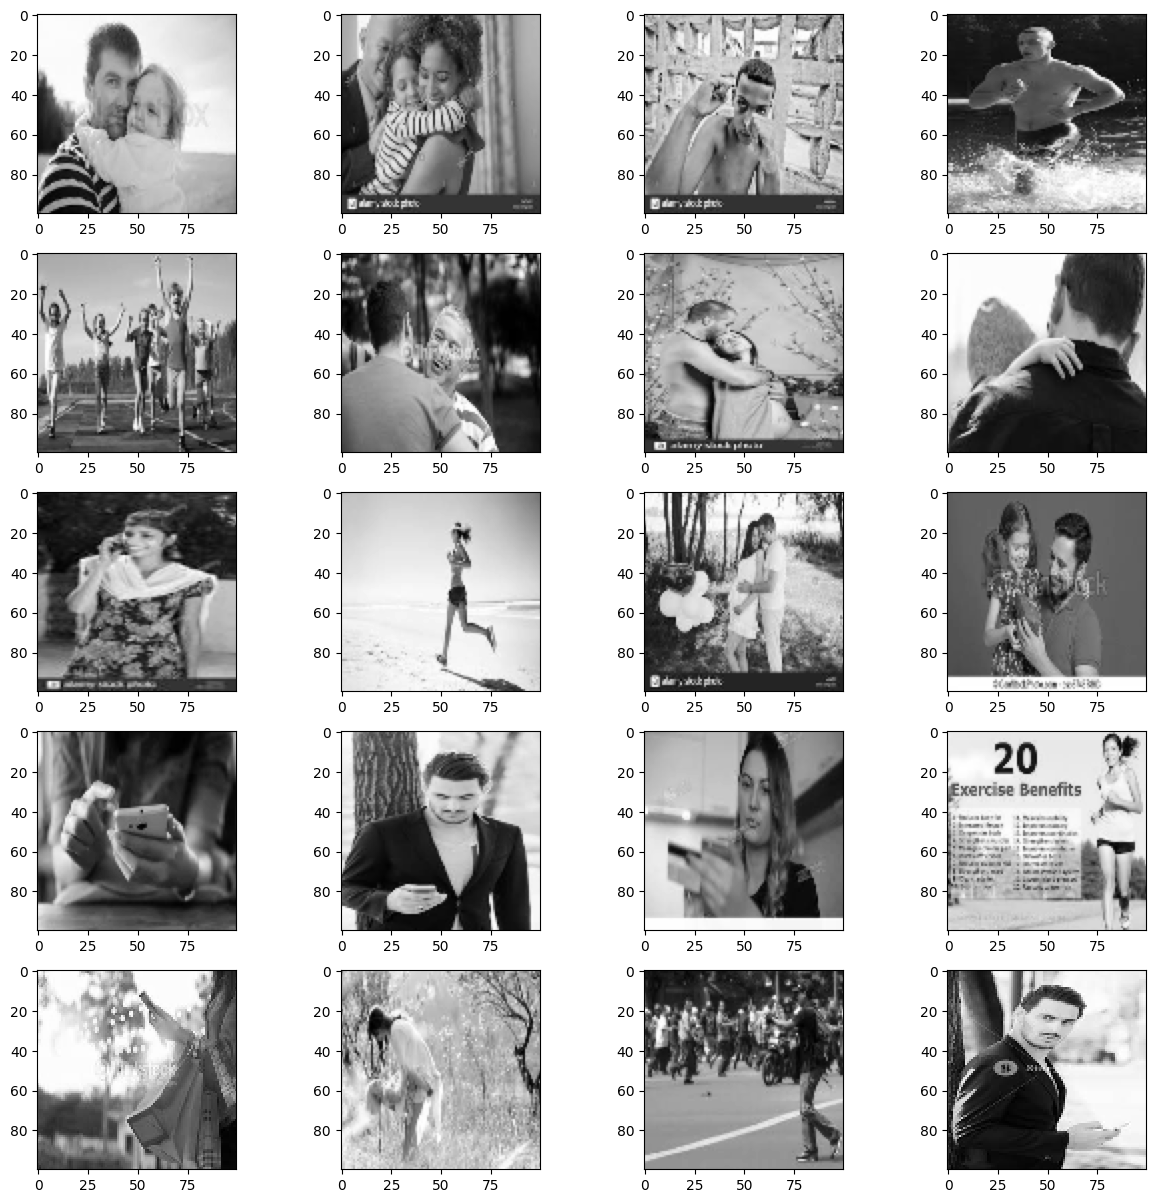

In [33]:
plot_images(
    images = train_images[0:20],
    shape=IMAGE_SHAPE
)

## Pre-processing

In [34]:
def resize(image_shape: tuple[int, int]):
    def threatment(img: np.ndarray) -> np.ndarray:
        return cv2.resize(img, image_shape)
    return threatment

## binarization

In [35]:
def standard_binarisation(img: np.ndarray) -> list[int]:
    return list(map(int, np.round(img.flatten() / 255)))

### Threshold

In [36]:
def apply_threshold(img: np.ndarray) -> np.ndarray:
    mean_light = img.mean()
    low  = mean_light * 0.9
    high = mean_light * 1.1
    _, t= cv2.threshold(img, low, high, cv2.THRESH_BINARY)
    return t

def apply_adaptative_threshold(img: np.ndarray) -> np.ndarray:
    t= cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11,2)
    return t

def apply_adaptative_gausian_threshold(img: np.ndarray) -> np.ndarray:
    t= cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11,2)
    return t

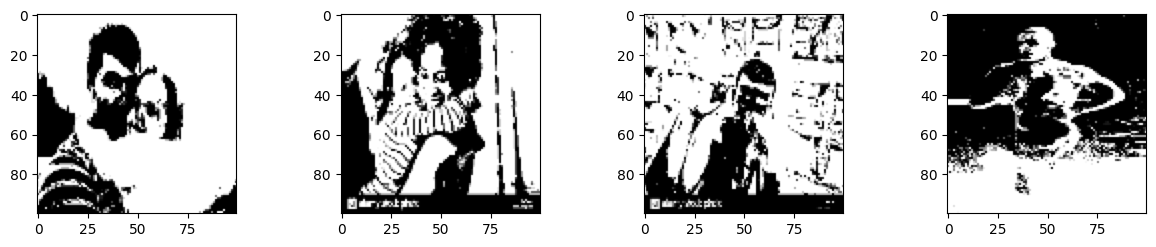

In [37]:
plot_images(
    images=list(map(apply_threshold, train_images[0:4])),
    shape=IMAGE_SHAPE,
)

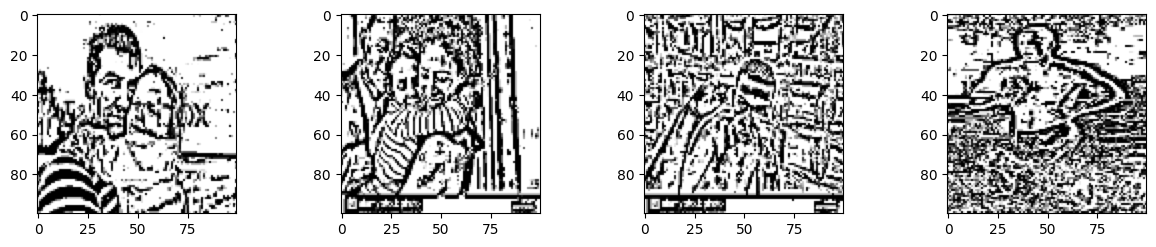

In [38]:
plot_images(
    images=list(map(apply_adaptative_threshold, train_images[0:4])),
    shape=IMAGE_SHAPE,
)

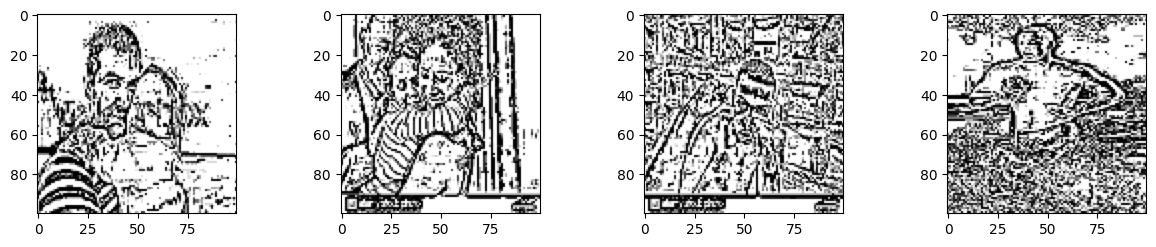

In [39]:
plot_images(
    images=list(map(apply_adaptative_gausian_threshold, train_images[0:4])),
    shape=IMAGE_SHAPE,
)

## Train

In [40]:
def train(
        *, 
        train_images: list[np.ndarray], 
        labels: list[str], 
        num_bits_addr: int = 14,
        ) -> tuple[any, float]:
    """train a model using images and labels

    Args:
        train_images (list[np.ndarray]): images loaded using open cv
        labels (list[str]): list of label

    Returns:
        tuple[any, float]: tuple with model, and acuracy
    """


    # Binarização

    # train_images_binary = [list(map(int, np.round(img.flatten() / 255))) for img in train_images]
    train_images_binary = train_images
    
    # Divisão do dataset entre treino e teste
    X_train, X_test, y_train, y_test = train_test_split(train_images_binary, labels, test_size=0.2, random_state=42)

    # Inicializa a Wisard
    minScore = 0.1 
    threshold = 10
    discriminatorLimit = 5

    model = wp.Wisard(num_bits_addr)
 

    # Treina o modelo
    model.train(X_train, y_train)

    # Previsão no teste
    y_pred = model.classify(X_test)

    # Acurácia
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy:', accuracy)
    return (model, accuracy)

In [41]:
hipotesis = {
    '100x100':{
        'treatments':[
            resize(image_shape=(100, 100)),
            standard_binarisation,
        ]
    },
    '30x30':{
        'treatments':[
            resize(image_shape=(30, 30)),
            standard_binarisation,
        ]
    },
    '200x200':{
        'treatments':[
            resize(image_shape=(200, 200)),
            standard_binarisation,
        ]
    },
    '200x200_threshold':{
        'treatments':[
            resize(image_shape=(200, 200)),
            apply_threshold,
            standard_binarisation,
        ]
    },
    '100x100_threshold':{
        'treatments':[
            resize(image_shape=(100, 100)),
            apply_threshold,
            standard_binarisation,
        ]
    },
    '100x100_adaptative_threshold':{
        'treatments':[
            resize(image_shape=(100, 100)),
            apply_adaptative_threshold,
            standard_binarisation,
        ]
    },
    '100x100_gausian_threshold':{
        'treatments':[
            resize(image_shape=(100, 100)),
            apply_adaptative_gausian_threshold,
            standard_binarisation,
        ]
    }
}


In [42]:
champion_model = None
champion_accuracy = 0.0

results = []
for case_name in hipotesis:
    params = hipotesis[case_name]

    # get params
    treatments = params['treatments']


    # call pre-processing here
    for func in treatments:
        train_images = list(map(func, train_images))


    # train
    for num_bits_addr in range(10, 50, 2):
        (model, accuracy) = train(
            train_images=train_images,
            labels=train_labels,
        )
        result = {
            'set': case_name,
            'params': params,
            'accuracy': accuracy,
            'num_bits_addr':num_bits_addr,
        }

        results.append(result)

        if accuracy > champion_accuracy:
            champion_model = result
            champion_accuracy = accuracy
            print(f'current champion is {result}')


Accuracy: 0.48214285714285715
current champion is {'set': '100x100', 'params': {'treatments': [<function resize.<locals>.threatment at 0x16cd25a80>, <function standard_binarisation at 0x16c19b420>]}, 'accuracy': 0.48214285714285715, 'num_bits_addr': 10}
Accuracy: 0.4732142857142857
Accuracy: 0.46130952380952384
Accuracy: 0.47023809523809523
Accuracy: 0.4583333333333333
Accuracy: 0.4642857142857143
Accuracy: 0.4732142857142857
Accuracy: 0.45535714285714285
Accuracy: 0.4568452380952381
Accuracy: 0.46279761904761907
Accuracy: 0.4583333333333333
Accuracy: 0.4538690476190476
Accuracy: 0.4836309523809524
current champion is {'set': '100x100', 'params': {'treatments': [<function resize.<locals>.threatment at 0x16cd25a80>, <function standard_binarisation at 0x16c19b420>]}, 'accuracy': 0.4836309523809524, 'num_bits_addr': 34}
Accuracy: 0.47023809523809523
Accuracy: 0.4851190476190476
current champion is {'set': '100x100', 'params': {'treatments': [<function resize.<locals>.threatment at 0x16cd2

error: OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [ ]:
df = pd.DataFrame({
    'set':[r['set'] for r in results],
    'params':[r['params'] for r in results],
    'accuracy':[r['accuracy'] for r in results],
    'num_bits_addr': [r['num_bits_addr'] for r in results]
})
df

,set,params,accuracy,num_bits_addr
0,100x100,{'treatments': [<function resize.<locals>.thre...,0.471726,10
1,100x100,{'treatments': [<function resize.<locals>.thre...,0.462798,12
2,100x100,{'treatments': [<function resize.<locals>.thre...,0.462798,14
3,100x100,{'treatments': [<function resize.<locals>.thre...,0.470238,16
4,100x100,{'treatments': [<function resize.<locals>.thre...,0.461310,18
...,...,...,...,...
135,100x100_gausian_threshold,{'treatments': [<function resize.<locals>.thre...,0.382440,40
136,100x100_gausian_threshold,{'treatments': [<function resize.<locals>.thre...,0.380952,42
137,100x100_gausian_threshold,{'treatments': [<function resize.<locals>.thre...,0.383929,44
138,100x100_gausian_threshold,{'treatments': [<function resize.<locals>.thre...,0.394345,46


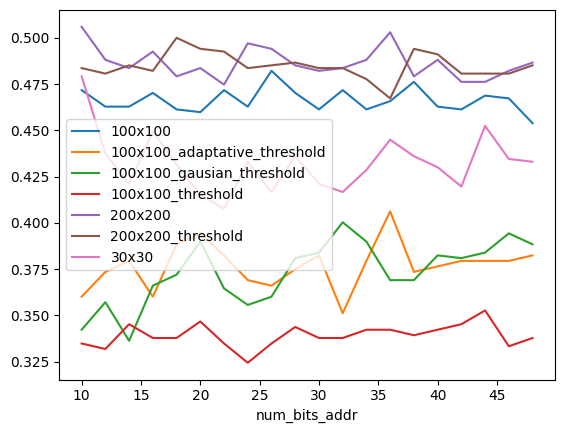

In [ ]:
fig, ax = plt.subplots()
for label, grp in df.groupby('set'):
    grp.plot(x = 'num_bits_addr', y = 'accuracy',ax = ax, label = label)